#  Setting up the Data

Adapted from https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py


Note: use Shift+Enter to run the codeblocks

In [3]:
import keras
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD, Adam
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib figure size and make inline
matplotlib.rcParams['figure.figsize'] = [10, 6]
%matplotlib inline

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Split our data into a training & testing set

`x_train` & `x_test` are the examples, and `y_train` & `y_test` are the labels.

In [11]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test  = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# normalize the pixel values to be in the range (0, 1)
x_train /= 255 
x_test  /= 255

#print(x_train.shape)
x_validation = x_train[58000:]
y_validation = y_train[58000:]
x_train = x_train[:58000]
y_train = y_train[:58000]
#y_validation = binary_data.iloc[10000:11000]['label'].as_matrix()


print("Number of training samples in full dataset: " + str(x_train.shape[0]))
print("Number of testing samples in full dataset: " + str(x_test.shape[0]))
print("Number of validation samples in full dataset: " + str(x_validation.shape[0]))

Number of training samples in full dataset: 58000
Number of testing samples in full dataset: 10000
Number of validation samples in full dataset: 2000


### Check out what our data looks like

Let's plot one of the training examples

The shape of each image is(784,)


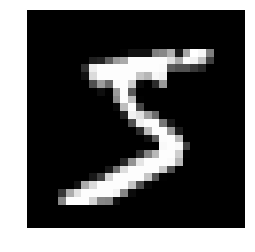

In [12]:
image = x_train[0]
img_rows, img_cols, channels = 28, 28, 1
image = np.reshape(image, [img_rows, img_cols])
plt.imshow(image, cmap='gray')
plt.axis('off')

# The shape of each image is a vector with 784 binary values ("pixels")
image_shape = x_train[0].shape
print("The shape of each image is" + str(image_shape))

# Multi-class classification!

###  Format the labels

The labels are currently formatted as numeric values, ie the image above has the label `5`.

Since we're training 10 binary classifiers, we need to convert the labels into binary values.

ie, the label `1` becomes the array `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`. The entry in the "1th" position is true, and all others are false. 


In [13]:
# classifying 10 digits
num_classes = 10


print("shape of our labels before" + str(y_train.shape))
print("the first 3 labels look like:") 
print(str(y_train[0:5]) + '\n')


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print("shape of our labels after" + str(y_train.shape))
print("the first 3 labels look like:") 
print(str(y_train[0:5]))

shape of our labels before(58000,)
the first 3 labels look like:
[5 0 4 1 9]

shape of our labels after(58000, 10)
the first 3 labels look like:
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


Now that our data is good to go, let's train our 10 classifiers!


### Let's make our model!!

In [14]:
logistic_reg_model = Sequential()
logistic_reg_model.add(Dense(num_classes, activation='softmax', input_shape=image_shape))

### Compile the model

In [15]:
logistic_reg_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

### Fit the model & store accuracies!

Note: turning on verbosity can slow things down *a lot* so if you're running some large model, turn it off.

In [16]:
global_batch_size = 128
num_epochs = 10

history = logistic_reg_model.fit(x_train, y_train,
                   batch_size=global_batch_size, # average 128 examples in each SGD test
                   epochs=num_epochs,
                   verbose=1,
                   validation_data=(x_validation, y_validation))


score = logistic_reg_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 58000 samples, validate on 10000 samples
Epoch 1/10
58000/58000 [==============================] - 1s 20us/step - loss: 1.3004 - acc: 0.6922 - val_loss: 0.8187 - val_acc: 0.8301
Epoch 2/10
58000/58000 [==============================] - 1s 14us/step - loss: 0.7281 - acc: 0.8387 - val_loss: 0.6118 - val_acc: 0.8598
Epoch 3/10
58000/58000 [==============================] - 1s 15us/step - loss: 0.5969 - acc: 0.8569 - val_loss: 0.5294 - val_acc: 0.8729
Epoch 4/10
58000/58000 [==============================] - 1s 17us/step - loss: 0.5341 - acc: 0.8659 - val_loss: 0.4832 - val_acc: 0.8813
Epoch 5/10
58000/58000 [==============================] - 1s 16us/step - loss: 0.4958 - acc: 0.8725 - val_loss: 0.4527 - val_acc: 0.8855
Epoch 6/10
58000/58000 [==============================] - 1s 17us/step - loss: 0.4694 - acc: 0.8775 - val_loss: 0.4314 - val_acc: 0.8903
Epoch 7/10
58000/58000 [==============================] - 1s 17us/step - loss: 0.4498 - acc: 0.8814 - val_loss: 0.4149 - val_acc

-----

# Learning MNIST with a Multilayer Network!

We'll set up a new model

In [ ]:
mlp_model = Sequential()
mlp_model.add(Dense(512, activation='relu', input_shape=image_shape))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dense(num_classes, activation='softmax'))

### Compile the MLP

We'll compile with the same parameters as before so that it's a fair comparison.

In [ ]:
mlp_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

### Fit & Evaluate

In [ ]:
global_batch_size = 128
num_epochs = 10

history = mlp_model.fit(x_train, y_train,
                   batch_size=global_batch_size, # average 128 examples in each SGD test
                   epochs=num_epochs,
                   verbose=1,
                   validation_data=(x_validation, y_validation))

score = mlp_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


-----
# How deep can you go: can adding more layers help us?

Creating a deep model gives us some performance gains, but it's not a panacea.  Let's see how model performance behaves as we add more layers.

In [ ]:
def depth_accuracy_analysis(x_train, y_train, x_test, y_test, max_layers, layer_size =128, verbose=False):
    # type: (np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int, bool) -> List[float]
    """This method creates deep feedforward networks of varyig depth from 1 layer to max_layers.  It
    returns a list of accuracies on the test set
    
    Args:
        x_train: An np.ndarray of data where each row is a new data point
        y_train: An np.ndarray of labels where each row is a binary vector with
            1 in the column of the associated class
        x_test: An np.ndarray of data where each row is a new data point
        y_test: An np.ndarray of labels where each row is a binary vector with
            1 in the column of the associated class
        max_layers: An int the maximum depth to try
        layer_size: The number of neurons in each layer
    
    Returns:
        A List of floats as the accuracies of the model on the test set
    """
    acc_scores = []
    
    # Build up and test 1 - max layers
    for i in range(0, max_layers):
        mlp_model = Sequential()
        mlp_model.add(Dense(layer_size, activation='relu', input_shape=x_train[0].shape))
        
        # Add i layers
        for j in range(1, i):
            mlp_model.add(Dense(layer_size, activation='relu'))

        mlp_model.add(Dense(y_train.shape[1], activation='softmax'))
        mlp_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
        history = mlp_model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=10,
                        verbose=0,
                        validation_data=(x_validation, y_validation))
        score = mlp_model.evaluate(x_test, y_test, verbose=0)
        
        # Print out scores if verbosity is non 0
        if verbose:
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])
        acc_scores.append(score)
    
    return acc_scores

In [ ]:
max_layers = 30
layer_size = 128
scores = depth_accuracy_analysis(x_train, y_train, x_test, y_test, max_layers, layer_size=layer_size)

In [ ]:
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, max_layers + 1), map(lambda x: x[1], scores), 'o-')
plt.title('Behaviour of model accuracy with depth')
plt.ylabel('Testing Accuracy')
plt.xlabel('Number of layers with {} nodes/layer'.format(layer_size))

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, max_layers + 1), map(lambda x: x[0], scores), 'o-')
plt.title('Behaviour of model loss with depth')
plt.ylabel('Testing loss')
plt.xlabel('Number of layers with {} nodes/layer'.format(layer_size))
plt.tight_layout()
plt.savefig('depth_experiment_{}-layers_{}-layer_size.png'.format(max_layers, layer_size))
plt.show()

Here are the results:

<img src="depth_experiment_30-layers_128-layer_size.png" width="800">

-----

# If adding more layers isn't helping, can we get smarter about the network?

There are many different types of layers that we can use when building a network.  Right now we have just seen dense layers which are simply perceptron-like nodes stacked together.  Here we will use a set of layers that are well adapted to images called convoluational, and pooling layers.  If you are interested in understanding how these work check out this great paper https://arxiv.org/pdf/1603.07285.pdf.  For now, you can think of the convlutional layers as learning filter like features of increasing complexity.  We will need to redefine our data in order to work with these layers.  Convolutions work on a matrix of values as opposed to a flattened array, because the filters take into consideration local patterns.

In [34]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
image_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_validation = x_train[58000:]
y_validation = y_train[58000:]
x_train = x_train[:58000]
y_train = y_train[:58000]

print('x_train shape:', x_train.shape)
print('x_val shape:  ', x_validation.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)

x_train shape: (58000, 28, 28, 1)
x_val shape:   (2000, 28, 28, 1)
58000 train samples
10000 test samples


In [38]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=image_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))

#cnn_model.summary()

In [36]:
cnn_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

In [37]:
history = cnn_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_validation, y_validation))

Train on 58000 samples, validate on 2000 samples
Epoch 1/10
  896/58000 [..............................] - ETA: 3:33 - loss: 2.2961 - acc: 0.0893

KeyboardInterrupt: 

#### Training CNN takes a long time, cutting to the chase:
Use GPU version of Keras for faster training.

Training:
<img src="cnn_train.png" width="800">

Testing:
<img src="cnn_test.png" width="800">

----
# State of the Art-ish Accuracy

The state of the art on MNIST is 99.79% accuracy.  With a little extra work we can push our conv net pretty close to this at ~99.16% accuracy.  We can do this by adding regularization in the form of drop out and a better optimizer in the form of ADAM.

In [14]:
# Best CNN
best_cnn_model = Sequential()
best_cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                   activation='relu',
                   input_shape=image_shape))
best_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
best_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
best_cnn_model.add(Dropout(.5))
best_cnn_model.add(Flatten())
best_cnn_model.add(Dense(128, activation='relu'))
best_cnn_model.add(Dropout(.5))
best_cnn_model.add(Dense(num_classes, activation='softmax'))

# best_cnn_model.summary()

In [15]:
best_cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [16]:
history = best_cnn_model.fit(x_train, y_train,
                             batch_size=128,
                             epochs=10,
                             verbose=1,
                             validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 200s 3ms/step - loss: 0.2575 - acc: 0.9207 - val_loss: 0.0586 - val_acc: 0.9803
Epoch 2/10
60000/60000 [==============================] - 182s 3ms/step - loss: 0.0971 - acc: 0.9712 - val_loss: 0.0378 - val_acc: 0.9872
Epoch 3/10
60000/60000 [==============================] - 178s 3ms/step - loss: 0.0759 - acc: 0.9770 - val_loss: 0.0353 - val_acc: 0.9879
Epoch 4/10
60000/60000 [==============================] - 177s 3ms/step - loss: 0.0608 - acc: 0.9812 - val_loss: 0.0284 - val_acc: 0.9902
Epoch 5/10
60000/60000 [==============================] - 192s 3ms/step - loss: 0.0539 - acc: 0.9832 - val_loss: 0.0263 - val_acc: 0.9917
Epoch 6/10
60000/60000 [==============================] - 197s 3ms/step - loss: 0.0467 - acc: 0.9853 - val_loss: 0.0299 - val_acc: 0.9904
Epoch 7/10
60000/60000 [==============================] - 187s 3ms/step - loss: 0.0450 - acc: 0.9860 - val_loss: 0.0269 - 

In [17]:
score = best_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0260217264686
Test accuracy: 0.9931


In [ ]:
#### Also very slow, here are the results:

Training:
<img src="best_train.png" width="800">

Testing:
<img src="best_test.png" width="800">
    

----
# Cool stuff with neural nets

- Michael Nielsen's book is awesome: http://neuralnetworksanddeeplearning.com/

- Lots of keras tutorials: https://github.com/fchollet/keras/tree/master/examples

- "Deep art": https://deepart.io/

- Adversarial Networks: https://blog.openai.com/adversarial-example-research/

- NN visualization: http://playground.tensorflow.org/

- Generated cat images from outlines: https://affinelayer.com/pixsrv/

- AlphaGo: https://deepmind.com/research/alphago/

- Music Generation: https://magenta.tensorflow.org/welcome-to-magenta
